In [1]:
import sys
import os

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from pathlib import Path
import importlib

import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt

from dask.distributed import Client
import dask.array
from dask.dataframe.utils import make_meta

from hats import read_hats
from hats.inspection import plot_pixels
from hats_import.catalog.file_readers import CsvReader
from hats_import.margin_cache.margin_cache_arguments import MarginCacheArguments
from hats_import.pipeline import ImportArguments, pipeline_with_client

import lsdb

from catalog_filtering import bandFilterLenient, contains_PM
import hpms_pipeline as hpms

print("Imported libraries.")

Imported libraries.


In [5]:
bandList = ['G','R','I','Z','Y']
class_star = None
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
mag = 19
query_string = bandFilterLenient(bandList,classStar=class_star,spreadModel=spread_model,magError=magnitude_error,flag=check_flags,mag=mag)
des_cols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
k = 2
max_obj_deviation = 0.2
pm_speed_min = 1000 #units are milliarcseconds per year
pm_speed_max = 10**5
des_id_col = 'COADD_OBJECT_ID_1'
mag_cols = [f'WAVG_MAG_PSF_{band}' for band in ['I']]
cone_search_rad = 25
min_neighbors = 3
max_neighbor_dist = 18
milliarc_degree_conversion = 1/(1000*3600)
xmatch_max_neighbors = 100
print("Defined local vars.")

Defined local vars.


In [6]:
# Change to the directories where the data will be stored
CATALOG_DIR = Path("../../../../catalogs")
MARGIN_CACHE_DIR = CATALOG_DIR / 'margin_caches'

GAIA_NAME = "gaia_dr3_pm_greater_100"
GAIA_DIR = CATALOG_DIR / GAIA_NAME

DES_NAME = "des_light"
DES_DIR = CATALOG_DIR / DES_NAME 

DES_X_GAIA_NAME = "des_dr2_x_gaia_dr3"
DES_X_GAIA_DIR = CATALOG_DIR / DES_X_GAIA_NAME
DES_MARGIN_CACHE_NAME = "des_margin_cache_18_arcsec"
DES_MARGIN_CACHE_DIR = MARGIN_CACHE_DIR / DES_MARGIN_CACHE_NAME

print("Defined directories.")

Defined directories.


In [7]:
des_catalog = lsdb.read_hats(DES_DIR)
gaia_catalog = lsdb.read_hats(GAIA_DIR)
xmatch_catalog = lsdb.read_hats(DES_X_GAIA_DIR, columns='all')
print("Defined catalogs.")

Defined catalogs.


In [8]:
%%time
pm_filter_xmatch = xmatch_catalog.query(f'{pm_speed_max**2} >(pmra_gaia**2 + pmdec_gaia**2) > {pm_speed_min**2}')
with Client():
    df = pm_filter_xmatch.compute()

df

CPU times: user 30.5 s, sys: 785 ms, total: 31.3 s
Wall time: 1min 18s


,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,FLAGS_Y_des,RA_des,DEC_des,COADD_OBJECT_ID_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,NEPOCHS_G_des,NEPOCHS_R_des,NEPOCHS_I_des,NEPOCHS_Z_des,NEPOCHS_Y_des,source_id_gaia,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,phot_g_mean_mag_gaia,phot_bp_mean_mag_gaia,phot_rp_mean_mag_gaia,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
613844718320588,0.880538,0.963898,0.983112,0.979363,0.595527,0,0,0,0,0,43.194227,1.924013,1343006866,-0.002108,-0.000071,0.00106,-0.000283,0.000484,22.757801,21.253117,20.287706,19.843111,19.703493,0.026349,0.008517,0.007532,0.006415,0.019259,7,7,4,7,6,1227712107314688,43.195868,1.928423,1400.291765,-515.645438,13.919317,14.903977,12.939081,16.939085
613854791118803,0.513397,0.702804,0.690331,0.556331,0.001543,1,1,1,1,1,43.198956,1.924676,1343006899,-0.004575,0.009738,0.01514,-0.017007,0.021923,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,1227712107314688,43.195868,1.928423,1400.291765,-515.645438,13.919317,14.903977,12.939081,17.476786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3289742749783385503,0.999789,0.999768,0.999853,0.999168,0.22071,3,3,3,3,3,322.705738,-40.715997,926149359,0.002088,0.007195,0.01138,0.014347,0.004569,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,6579485487647973888,322.704773,-40.714388,1046.642165,-1396.306284,11.778023,13.375048,10.548469,6.364448
3289742749975291194,0.030484,0.097534,0.844041,0.842068,0.628413,3,3,3,3,3,322.70503,-40.714652,926147617,0.021968,0.046018,0.04153,0.04223,0.048809,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,6579485487647973888,322.704773,-40.714388,1046.642165,-1396.306284,11.778023,13.375048,10.548469,1.182722


In [9]:
df_no_dupes = df[~df['source_id_gaia'].duplicated(keep='first')]

gaia_ids = df['source_id_gaia']

#dropping because otherwise produces error when performing .apply below
df_no_dupes = df_no_dupes.drop('source_id_gaia', axis=1)

df_no_dupes

,CLASS_STAR_G_des,CLASS_STAR_R_des,CLASS_STAR_I_des,CLASS_STAR_Z_des,CLASS_STAR_Y_des,FLAGS_G_des,FLAGS_R_des,FLAGS_I_des,FLAGS_Z_des,FLAGS_Y_des,RA_des,DEC_des,COADD_OBJECT_ID_des,SPREAD_MODEL_G_des,SPREAD_MODEL_R_des,SPREAD_MODEL_I_des,SPREAD_MODEL_Z_des,SPREAD_MODEL_Y_des,WAVG_MAG_PSF_G_des,WAVG_MAG_PSF_R_des,WAVG_MAG_PSF_I_des,WAVG_MAG_PSF_Z_des,WAVG_MAG_PSF_Y_des,WAVG_MAGERR_PSF_G_des,WAVG_MAGERR_PSF_R_des,WAVG_MAGERR_PSF_I_des,WAVG_MAGERR_PSF_Z_des,WAVG_MAGERR_PSF_Y_des,NEPOCHS_G_des,NEPOCHS_R_des,NEPOCHS_I_des,NEPOCHS_Z_des,NEPOCHS_Y_des,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,phot_g_mean_mag_gaia,phot_bp_mean_mag_gaia,phot_rp_mean_mag_gaia,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
613844718320588,0.880538,0.963898,0.983112,0.979363,0.595527,0,0,0,0,0,43.194227,1.924013,1343006866,-0.002108,-0.000071,0.00106,-0.000283,0.000484,22.757801,21.253117,20.287706,19.843111,19.703493,0.026349,0.008517,0.007532,0.006415,0.019259,7,7,4,7,6,43.195868,1.928423,1400.291765,-515.645438,13.919317,14.903977,12.939081,16.939085
1153482605725265461,0.844888,0.845371,0.844807,0.845333,0.844827,3,3,3,3,3,1.386363,-37.369781,1043295027,-0.015229,0.040008,0.037639,0.034238,0.050002,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,1.383284,-37.367744,5633.438088,-2334.721273,7.682494,8.802319,6.61627,11.461677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263270778643414534,0.530344,0.565081,0.25516,0.771278,0.506456,1,1,1,1,1,352.558439,-47.618479,1010242107,-0.001722,-0.005203,0.00807,0.031992,-0.013712,-99.0,24.201725,-99.0,-99.0,-99.0,-99.0,0.241926,-99.0,-99.0,-99.0,0,1,0,0,0,352.563657,-47.61685,-562.651573,-973.694222,15.216914,18.328148,13.734485,13.953139
3289742749783385503,0.999789,0.999768,0.999853,0.999168,0.22071,3,3,3,3,3,322.705738,-40.715997,926149359,0.002088,0.007195,0.01138,0.014347,0.004569,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,322.704773,-40.714388,1046.642165,-1396.306284,11.778023,13.375048,10.548469,6.364448


In [15]:
def algo_found_pm(row, des_cols, cone_search_rad, 
                  query_string, max_neighbor_dist, k,
                  max_obj_deviation, id_col, xmatch_max_neighbors,
                  mag_cols, min_neighbors):    
    # Filter DES around PM of interest:
    catalog = (
        lsdb.read_hats(DES_DIR, columns=des_cols, margin_cache=DES_MARGIN_CACHE_DIR)
        .cone_search(ra=row['ra_gaia'], dec=row['dec_gaia'], radius_arcsec=cone_search_rad)
    )
    
    with Client():
        filtered_df = hpms.execute_pipeline(catalog, query_string, xmatch_max_neighbors, 
                                   max_neighbor_dist, min_neighbors, k, max_obj_deviation, id_col, mag_cols, debug_mode=False).compute()
    if not filtered_df.empty:
        min_idx = filtered_df['kth_min_deviation'].idxmin()
        best_row = filtered_df.loc[min_idx]
        return pd.Series({
            'kth_min_deviation': best_row['kth_min_deviation'],
            'max_obj_distance': best_row['max_obj_distance'],
            'max_mag_diff': best_row['max_mag_diff']
        })
    else:
        print('EMPTY')
        return pd.Series({
            'kth_min_deviation': np.nan,
            'max_obj_distance': np.nan,
            'max_mag_diff': np.nan
        })

In [16]:
importlib.reload(hpms)

print("Done")

Done


In [17]:
res = df_no_dupes.apply(func=algo_found_pm, axis=1, des_cols=des_cols, cone_search_rad=cone_search_rad, 
                        query_string=query_string, max_neighbor_dist=max_neighbor_dist, k=k, 
                        max_obj_deviation=max_obj_deviation, id_col=des_id_col, mag_cols=mag_cols, min_neighbors=min_neighbors,
                        xmatch_max_neighbors=xmatch_max_neighbors)
res

EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY


2025-07-02 10:51:09,887 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/ocean/projects/phy210048p/jpassos/conda-venvs/lsdb-main/lib/python3.12/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/

EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY
EMPTY


,kth_min_deviation,max_obj_distance,max_mag_diff
_healpix_29,,,
613844718320588,NaN,NaN,NaN
1153482605725265461,NaN,NaN,NaN
...,...,...,...
3263270778643414534,NaN,NaN,NaN
3289742749783385503,NaN,NaN,NaN


In [18]:
df_combined = df_no_dupes.join(res)
df_combined.columns

Index(['CLASS_STAR_G_des', 'CLASS_STAR_R_des', 'CLASS_STAR_I_des',
       'CLASS_STAR_Z_des', 'CLASS_STAR_Y_des', 'FLAGS_G_des', 'FLAGS_R_des',
       'FLAGS_I_des', 'FLAGS_Z_des', 'FLAGS_Y_des', 'RA_des', 'DEC_des',
       'COADD_OBJECT_ID_des', 'SPREAD_MODEL_G_des', 'SPREAD_MODEL_R_des',
       'SPREAD_MODEL_I_des', 'SPREAD_MODEL_Z_des', 'SPREAD_MODEL_Y_des',
       'WAVG_MAG_PSF_G_des', 'WAVG_MAG_PSF_R_des', 'WAVG_MAG_PSF_I_des',
       'WAVG_MAG_PSF_Z_des', 'WAVG_MAG_PSF_Y_des', 'WAVG_MAGERR_PSF_G_des',
       'WAVG_MAGERR_PSF_R_des', 'WAVG_MAGERR_PSF_I_des',
       'WAVG_MAGERR_PSF_Z_des', 'WAVG_MAGERR_PSF_Y_des', 'NEPOCHS_G_des',
       'NEPOCHS_R_des', 'NEPOCHS_I_des', 'NEPOCHS_Z_des', 'NEPOCHS_Y_des',
       'ra_gaia', 'dec_gaia', 'pmra_gaia', 'pmdec_gaia',
       'phot_g_mean_mag_gaia', 'phot_bp_mean_mag_gaia',
       'phot_rp_mean_mag_gaia', '_dist_arcsec', 'kth_min_deviation',
       'max_obj_distance', 'max_mag_diff'],
      dtype='object')

In [19]:
for val in df_combined['max_mag_diff']:
    print(val)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.0075817108154296875
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
6.234375
nan
0.0034656524658203125
nan
0.020755767822265625
nan
nan
nan
nan
nan
nan
nan


In [20]:
def plot_pms_helper(df, check_column, cone_search_rad, title_prefix):
    df_loop = df[~np.isnan(df[check_column])]
    # Get the number of rows that meet the condition
    rows_count = df_loop.shape[0]
    
    # Create subplots
    fig, axs = plt.subplots(rows_count, 1, figsize=(6, rows_count * 4))
    
    # If there is only one subplot, axs is not an array, so we handle it separately
    if rows_count == 1:
        axs = [axs]

    plot_index = 0
    for index, row in df_loop.iterrows():
        filtered_catalog = (
            lsdb.read_hats(DES_DIR, columns=['RA','DEC'])
            .cone_search(ra=row['ra_gaia'], dec=row['dec_gaia'], radius_arcsec=cone_search_rad)
        )
        df_catalog = filtered_catalog.compute()
        RA, DEC = df_catalog[["RA", "DEC"]].to_numpy().T
        
        origin = row['ra_gaia'], row['dec_gaia']

        #multiplied by 3 to show how far the star would travel in 3 years (max time star could move given the time domains of DES and gaia)
        #do not multiply by 3 to have true PM vectors
        vx = (row['pmra_gaia'] / np.cos(np.radians(row['dec_gaia']))) * milliarc_degree_conversion * 3
        vy = row['pmdec_gaia'] * milliarc_degree_conversion * 3
        
        norm = np.sqrt(vx**2 + vy**2)
        
        if norm != 0:
            unit_vector = np.array((vx / norm, vy / norm))
        else:
            unit_vector = np.array((np.nan, np.nan))  # or (0, 0) depending on your use case

        vector = (vx, vy)

        max_dist_vector = unit_vector * row['max_obj_distance'] / 3600
        #small displacement to not overlap pm vector
        max_dist_origin = (origin[0], origin[1] - 0.001)


        axs[plot_index].scatter(RA, DEC)
        axs[plot_index].quiver(*origin, *vector, angles='xy', scale_units='xy', scale=1, color='red')
        axs[plot_index].quiver(*max_dist_origin, *max_dist_vector, angles='xy', scale_units='xy', scale=1, color='green')
        axs[plot_index].set_xlabel('RA (Degrees)')
        axs[plot_index].set_ylabel('DEC (Degrees)')
        axs[plot_index].set_title(f'{title_prefix} Stars Near Gaia PMS {index}')
        axs[plot_index].invert_xaxis()

        height = width = (cone_search_rad * 0.5)/3600
        axs[plot_index].set_xlim(row['ra_gaia'] - width, row['ra_gaia'] + width)
        axs[plot_index].set_ylim(row['dec_gaia'] - height, row['dec_gaia'] + height)
        plot_index += 1
    
    plt.tight_layout()
    plt.show()

def plot_found_pms(df, check_column, cone_search_rad):
    plot_pms_helper(df, check_column, cone_search_rad, "Found")

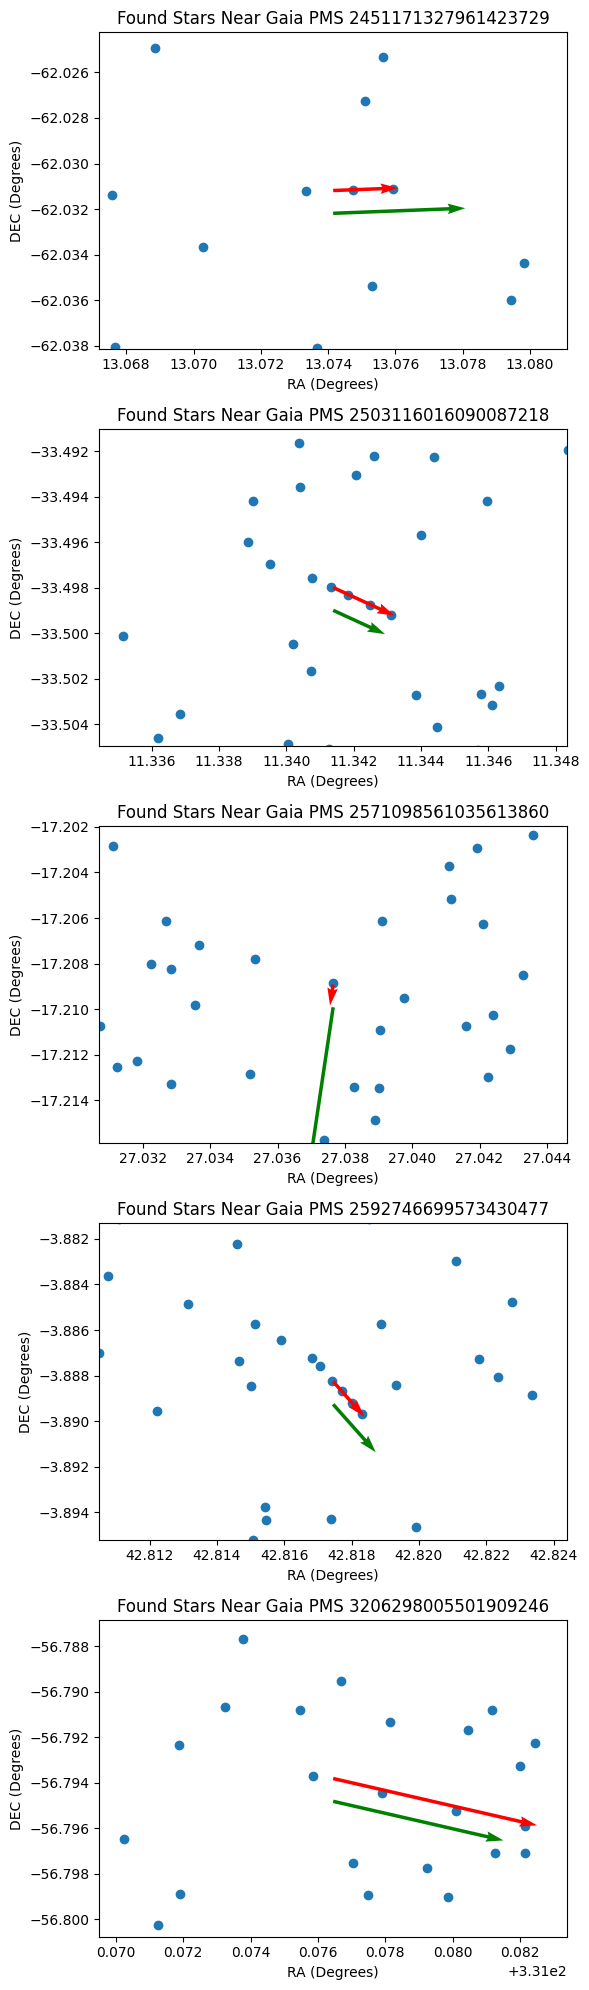

In [32]:
plot_found_pms(df=df_combined, check_column='kth_min_deviation', cone_search_rad=50)